# Оценка RAG системы с помощью Ragas

## Сохранение метрик

После выполнения оценки все метрики автоматически сохраняются в `rag/tests/`:
- `ragas_evaluation_results.csv` - полные результаты Ragas метрик
- `retrieval_evaluation_results.csv` - результаты retrieval метрик
- `all_evaluation_metrics.json` - сводка всех метрик (Ragas + Retrieval)

## Работа с удаленным сервисом

Ноутбук работает с **удаленным RAG сервисом** по адресу: `http://176.123.161.187:8000`


## Метрики Ragas:

### Retrieval (Поиск):
- **Context Precision** - точность извлеченного контекста
- **Context Recall** - полнота извлеченного контекста

### Generation (Генерация):
- **Faithfulness** - достоверность (отсутствие галлюцинаций)
- **Answer Relevancy** - релевантность ответа вопросу
- **Answer Correctness** - правильность ответа (с ground truth)
- **Answer Similarity** - семантическая схожесть (с ground truth)

## Требования:

### 1. Установка пакетов:
```bash
uv pip install ragas datasets requests python-dotenv langchain-openai
```

### 2. Настройка .env файла:
Создайте файл `.env` в папке `rag/` с содержимым:
```env
OPENAI_API_KEY=your-api-key-here
OPENAI_API_BASE=https://your-api-base-url  # опционально, для кастомного endpoint

# Опциональные настройки моделей (по умолчанию используются gpt-4o-mini и text-embedding-3-small)
RAGAS_LLM_MODEL=gpt-4o-mini  # или другая доступная модель в вашем API
RAGAS_EMBEDDING_MODEL=text-embedding-3-small  # или другая доступная модель
``


## 1. Импорты и настройка


In [1]:
import json
import os
from pathlib import Path
from typing import List, Dict, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import requests
from dotenv import load_dotenv

# Загружаем переменные окружения из .env файла
load_dotenv()

# Ragas imports
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
    answer_correctness,
    answer_similarity,
)
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Настройка OpenAI для Ragas
openai_api_key = os.getenv('OPENAI_API_KEY', '')
openai_api_base = os.getenv('OPENAI_API_BASE')

# Настройки моделей (измените на доступные в вашем API)
LLM_MODEL = os.getenv('RAGAS_LLM_MODEL', 'gpt-4o-mini')  # Модель для оценки
EMBEDDING_MODEL = os.getenv('RAGAS_EMBEDDING_MODEL', 'text-embedding-3-small')  # Модель для эмбеддингов
MAX_TOKENS = 5000  # Лимит токенов для генерации

# Создаем кастомные LLM и Embeddings с base_url
llm_kwargs = {
    "model": LLM_MODEL,
    "api_key": openai_api_key,
    "max_tokens": MAX_TOKENS,
    "temperature": 0,  # Для стабильности оценок
    "n": 1,
    "timeout": 120,  # Таймаут 120 секунд (2 минуты)
    "max_retries": 3,  # Количество повторных попыток
}
emb_kwargs = {
    "model": EMBEDDING_MODEL,
    "api_key": openai_api_key,
    "timeout": 60,  # Таймаут 60 секунд для эмбеддингов
    "max_retries": 3,
}

if openai_api_base:
    llm_kwargs["base_url"] = openai_api_base
    emb_kwargs["base_url"] = openai_api_base

# Инициализируем LLM и Embeddings для Ragas
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(**llm_kwargs))
evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(**emb_kwargs))

# Настройка визуализации
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

print("✅ Все модули импортированы успешно")
print(f"🔑 OpenAI API Key: {'✓ установлен' if openai_api_key else '✗ не найден'}")
if openai_api_base:
    print(f"🌐 OpenAI API Base: {openai_api_base}")
else:
    print(f"🌐 OpenAI API Base: стандартный (api.openai.com)")
print(f"🤖 LLM Model: {LLM_MODEL}")
print(f"📊 Embedding Model: {EMBEDDING_MODEL}")
print(f"🎯 Max Tokens: {MAX_TOKENS}")
print(f"⏱️ LLM Timeout: {llm_kwargs['timeout']}s | Retries: {llm_kwargs['max_retries']}")
print(f"⏱️ Embedding Timeout: {emb_kwargs['timeout']}s | Retries: {emb_kwargs['max_retries']}")


/Users/maksimpiskaev/Проекты/lifelong_learning_assistant/rag/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Все модули импортированы успешно
🔑 OpenAI API Key: ✓ установлен
🌐 OpenAI API Base: https://api.ai-mediator.ru/v1
🤖 LLM Model: gpt-4o-mini
📊 Embedding Model: text-embedding-3-small
🎯 Max Tokens: 5000
⏱️ LLM Timeout: 120s | Retries: 3
⏱️ Embedding Timeout: 60s | Retries: 3


/var/folders/1r/cqqk6zj11qv5nqfgj28d6pzc0000gn/T/ipykernel_45379/2681482364.py:62: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  evaluator_llm = LangchainLLMWrapper(ChatOpenAI(**llm_kwargs))
/var/folders/1r/cqqk6zj11qv5nqfgj28d6pzc0000gn/T/ipykernel_45379/2681482364.py:63: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(**emb_kwargs))


## 2. Настройка подключения к RAG сервису


In [2]:
# URL удаленного RAG сервиса
RAG_SERVICE_URL = "http://176.123.161.187:8000"

print("🚀 Проверка подключения к RAG сервису...")
print(f"URL: {RAG_SERVICE_URL}")

try:
    # Проверяем доступность сервиса
    response = requests.get(f"{RAG_SERVICE_URL}/health", timeout=10)
    response.raise_for_status()
    health_data = response.json()
    
    print("RAG сервис доступен!")
    print(f"   Статус: {health_data.get('status', 'unknown')}")
    print(f"   Qdrant: {'✓' if health_data.get('qdrant_connected') else '✗'}")
    print(f"   Redis: {'✓' if health_data.get('redis_connected') else '✗'}")
    print(f"   Коллекция: {'✓' if health_data.get('collection_exists') else '✗'}")
    if health_data.get('collection_vectors_count'):
        print(f"   Векторов в коллекции: {health_data['collection_vectors_count']}")
    
except requests.exceptions.RequestException as e:
    print(f"Ошибка подключения к RAG сервису: {e}")


🚀 Проверка подключения к RAG сервису...
URL: http://176.123.161.187:8000
RAG сервис доступен!
   Статус: healthy
   Qdrant: ✓
   Redis: ✓
   Коллекция: ✓
   Векторов в коллекции: 2071


## 3. Тестовый запрос к RAG сервису


In [3]:
# Функция для вызова удаленного RAG сервиса
def call_rag_service(
    question: str,
    service_url: str,
    use_hyde: bool = False,
    top_k: int = 5,
    temperature: float = 0.4,
    timeout: int = 60
) -> Dict[str, Any]:
    """
    Вызов удаленного RAG сервиса через API
    
    Args:
        question: Вопрос пользователя
        service_url: URL RAG сервиса
        use_hyde: Использовать HyDE
        top_k: Количество документов
        temperature: Температура генерации
        timeout: Таймаут запроса в секундах
    
    Returns:
        Ответ от RAG сервиса
    """
    endpoint = f"{service_url}/rag"
    payload = {
        "query": question,
        "top_k": top_k,
        "temperature": temperature,
        "use_hyde": use_hyde
    }
    
    try:
        response = requests.post(endpoint, json=payload, timeout=timeout)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        raise Exception(f"Ошибка при вызове RAG сервиса: {e}")


# Тестовый запрос для проверки работы сервиса
test_question = "Что такое байесовский подход в машинном обучении?"

print(f"Тестовый запрос: {test_question}\n")

try:
    test_result = call_rag_service(
        question=test_question,
        service_url=RAG_SERVICE_URL,
        use_hyde=False,
        top_k=3
    )
    
    print("Сервис работает корректно!")
    print(f"\nОтвет (первые 200 символов):")
    print(test_result['answer'][:200] + "...")
    print(f"\nСтатистика:")
    print(f"   - Найдено документов: {test_result['num_documents_used']}")
    print(f"   - Токенов в контексте: {test_result['total_tokens_context']}")
    print(f"   - HyDE использован: {test_result.get('used_hyde', False)}")
    
except Exception as e:
    print(f"❌ Ошибка при тестовом запросе: {e}")


Тестовый запрос: Что такое байесовский подход в машинном обучении?

Сервис работает корректно!

Ответ (первые 200 символов):
Байесовский подход в машинном обучении основывается на использовании теоремы Байеса для обновления вероятностных оценок параметров моделей по мере поступления новых данных. Основные аспекты байесовско...

Статистика:
   - Найдено документов: 3
   - Токенов в контексте: 2168
   - HyDE использован: False


## 4. Загрузка тестового датасета


In [40]:
# Путь к датасету (используем новый датасет с 10 вопросами и эталонными ответами)
dataset_path = Path.cwd().parent / 'tests' / 'dataset_10.json'

# Загружаем датасет
with open(dataset_path, 'r', encoding='utf-8') as f:
    questions_data = json.load(f)

print(f"Загружено {len(questions_data)} вопросов")

print(json.dumps(questions_data[0], indent=2, ensure_ascii=False))


Загружено 681 вопросов
{
  "question": "Какой обзор является основным источником материала в документе, кроме части про AdaGrad?",
  "answer": "Обзор Х. Брендана МакМахана под названием «A Survey of Algorithms and Analysis for Adaptive Online Learning».",
  "doc": "adaptivnyj-ftrl.md"
}


## 5. Настройка параметров оценки


In [41]:
# Параметры оценки
USE_HYDE = True  # Использовать HyDE для улучшения поиска
TOP_K = 10         # Количество документов для контекста
LIMIT = None      # Ограничение количества вопросов (None = все 100 вопросов)
TEMPERATURE = 0 # Температура генерации

print("Параметры оценки:")
print(f"  - HyDE: {USE_HYDE}")
print(f"  - Top-K: {TOP_K}")
print(f"  - Limit: {LIMIT if LIMIT else f'все вопросы ({len(questions_data)})'}")
print(f"  - Temperature: {TEMPERATURE}")


Параметры оценки:
  - HyDE: True
  - Top-K: 10
  - Limit: все вопросы (681)
  - Temperature: 0


## 6. Подготовка датасета для Ragas

Ragas требует датасет в специальном формате:
- `question`: вопрос пользователя
- `answer`: сгенерированный ответ
- `contexts`: список извлеченных документов
- `ground_truth`: эталонный ответ (опционально)


In [ ]:
def prepare_ragas_dataset(
    questions_data: List[Dict],
    service_url: str,
    use_hyde: bool = False,
    top_k: int = 10,
    temperature: float = 0.0,
    limit: int = None
) -> Dataset:
    """
    Подготовка датасета в формате Ragas через вызовы к удаленному RAG сервису
    
    Датасет должен содержать:
    - question: вопрос
    - answer: сгенерированный ответ
    - contexts: список извлеченных документов
    - ground_truth: эталонный ответ
    - retrieved_docs: список имен найденных документов
    - expected_doc: ожидаемый документ (из датасета)
    - doc_positions: позиции найденных документов
    """
    if limit:
        questions_data = questions_data[:limit]
    
    # Подготовка данных для Ragas
    ragas_data = {
        'question': [],
        'answer': [],
        'contexts': [],
        'ground_truth': [],
        'retrieved_docs': [],      # Список найденных документов
        'expected_doc': [],         # Ожидаемый документ
        'doc_positions': []         # Позиции документов в выдаче
    }
    
    print(f"\nОбработка {len(questions_data)} вопросов...\n")
    
    for i, item in enumerate(tqdm(questions_data, desc="Генерация ответов"), 1):
        question = item['question']
        expected_doc = item.get('doc', '')  # Ожидаемый документ из датасета
        
        try:
            # Вызываем удаленный RAG сервис
            result = call_rag_service(
                question=question,
                service_url=service_url,
                top_k=top_k,
                temperature=temperature,
                use_hyde=use_hyde
            )
            
            # Извлекаем контексты из ответа API
            contexts = [doc['content'] for doc in result['documents']]
            
            # Извлекаем имена файлов найденных документов
            retrieved_docs = [
                doc['metadata'].get('filename', '') 
                for doc in result['documents']
            ]
            
            # Определяем позиции найденных документов
            # Позиция = индекс в списке (начиная с 1) или 0 если не найден
            doc_positions = {}
            for idx, doc_name in enumerate(retrieved_docs, 1):
                if doc_name:
                    doc_positions[doc_name] = idx
            
            # Используем эталонный ответ из датасета как ground_truth
            ground_truth = item.get('answer', '')
            
            # Добавляем в датасет
            ragas_data['question'].append(question)
            ragas_data['answer'].append(result['answer'])
            ragas_data['contexts'].append(contexts)
            ragas_data['ground_truth'].append(ground_truth)
            ragas_data['retrieved_docs'].append(retrieved_docs)
            ragas_data['expected_doc'].append(expected_doc)
            ragas_data['doc_positions'].append(doc_positions)
            
        except Exception as e:
            print(f"\nОшибка при обработке вопроса {i}: {e}")
            continue
    
    print(f"\nУспешно обработано {len(ragas_data['question'])} вопросов")
    
    # Создаем Dataset для Ragas
    dataset = Dataset.from_dict(ragas_data)
    return dataset


In [44]:
# Подготавливаем датасет через вызовы к удаленному RAG сервису
ragas_dataset = prepare_ragas_dataset(
    questions_data=questions_data,
    service_url=RAG_SERVICE_URL,
    use_hyde=USE_HYDE,
    top_k=TOP_K,
    temperature=TEMPERATURE,
    limit=LIMIT
)

print(f"\nДатасет готов: {len(ragas_dataset)} примеров")
print(f"\nКолонки: {ragas_dataset.column_names}")


🔄 Обработка 681 вопросов...



Генерация ответов:  96%|█████████▋| 656/681 [2:05:31<14:04, 33.80s/it]  


❌ Ошибка при обработке вопроса 656: Ошибка при вызове RAG сервиса: HTTPConnectionPool(host='176.123.161.187', port=8000): Read timed out. (read timeout=60)


Генерация ответов: 100%|██████████| 681/681 [2:10:17<00:00, 11.48s/it]


✅ Успешно обработано 680 вопросов

Датасет готов: 680 примеров

Колонки: ['question', 'answer', 'contexts', 'ground_truth', 'retrieved_docs', 'expected_doc', 'doc_positions']


In [45]:
# Сохраняем датасет для повторного использования
output_dir = Path.cwd().parent / 'tests'
output_dir.mkdir(exist_ok=True)

# Сохраняем в формате JSON
dataset_dict = ragas_dataset.to_dict()
dataset_path = output_dir / f'ragas_dataset_prepared_hyde_{USE_HYDE}_top{TOP_K}.json'
with open(dataset_path, 'w', encoding='utf-8') as f:
    json.dump(dataset_dict, f, indent=2, ensure_ascii=False)

print(f"\n💾 Датасет сохранен: {dataset_path}")
print(f"   Размер: {dataset_path.stat().st_size / 1024:.1f} KB")
print(f"\n💡 Вы можете загрузить этот датасет позже:")
print(f"   dataset = Dataset.from_dict(json.load(open('{dataset_path.name}')))")



💾 Датасет сохранен: /Users/maksimpiskaev/Проекты/lifelong_learning_assistant/rag/tests/ragas_dataset_prepared_hyde_True_top10.json
   Размер: 14193.5 KB

💡 Вы можете загрузить этот датасет позже:
   dataset = Dataset.from_dict(json.load(open('ragas_dataset_prepared_hyde_True_top10.json')))


In [3]:
# Раскомментируйте для загрузки существующего датасета
dataset_path = Path.cwd().parent / 'tests' / 'ragas_dataset_prepared_hyde_True_top10.json'
with open(dataset_path, 'r', encoding='utf-8') as f:
    dataset_dict = json.load(f)
ragas_dataset = Dataset.from_dict(dataset_dict)
print(f"✅ Датасет загружен: {len(ragas_dataset)} примеров")

✅ Датасет загружен: 680 примеров


## 7. Просмотр примера из датасета


In [4]:
ragas_dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth', 'retrieved_docs', 'expected_doc', 'doc_positions'],
    num_rows: 680
})

In [5]:
# Смотрим первый пример
example = ragas_dataset[0]

print("📝 Пример из датасета:\n")
print(f"Вопрос: {example['question']}\n")
print(f"Ответ: {example['answer'][:300]}...\n")
print(f"Количество контекстов: {len(example['contexts'])}")
print(f"\nПервый контекст (первые 200 символов):\n{example['contexts'][0][:200]}...\n")
print(f"Ground Truth: {example['ground_truth']}")


📝 Пример из датасета:

Вопрос: Какой обзор является основным источником материала в документе, кроме части про AdaGrad?

Ответ: Основным источником материала в документе, кроме части про AdaGrad, является обзор методов оптимизации в глубоких нейронных сетях, представленный в документе 2, который называется "Собираем все идеи воедино". В этом документе обсуждаются различные концепции и методы оптимизации, такие как адаптивные...

Количество контекстов: 4

Первый контекст (первые 200 символов):
## скользящее среднее в знаменателе adagrad. методы rmsprop и adam ### мотивация в далекие 2012-2014е в мире было не так много опыта по построению хороших нейросетевых архитектур. «канонические» метод...

Ground Truth: Обзор Х. Брендана МакМахана под названием «A Survey of Algorithms and Analysis for Adaptive Online Learning».


## 8.1 Кастомные метрики для Retrieval

Добавим метрики для оценки качества поиска документов:
- **Document Precision** - точность найденных документов
- **Document Recall** - полнота найденных документов
- **MRR (Mean Reciprocal Rank)** - средний обратный ранг правильного документа


In [6]:
def calculate_retrieval_metrics(dataset: Dataset) -> Dict[str, Any]:
    """
    Рассчитывает метрики качества retrieval:
    - Document Precision@K - доля правильных документов среди найденных
    - Document Recall - был ли найден правильный документ
    - MRR (Mean Reciprocal Rank) - средний обратный ранг правильного документа
    - Hit Rate@K - доля запросов, где правильный документ в топ-K
    """
    
    precisions = []
    recalls = []
    reciprocal_ranks = []
    hits_at_k = {1: [], 3: [], 5: [], 10: []}
    doc_positions_list = []
    
    for i in range(len(dataset)):
        expected_doc = dataset[i]['expected_doc']
        retrieved_docs = dataset[i]['retrieved_docs']
        doc_positions = dataset[i]['doc_positions']
        
        # Precision: правильный документ найден?
        is_found = expected_doc in retrieved_docs
        precision = 1.0 if is_found else 0.0
        precisions.append(precision)
        
        # Recall: для одного документа это то же, что и precision
        recalls.append(precision)
        
        # MRR: обратный ранг правильного документа
        if expected_doc in doc_positions and doc_positions[expected_doc] is not None:
            rank = doc_positions[expected_doc]
            reciprocal_ranks.append(1.0 / rank)
            doc_positions_list.append(rank)
            
            # Hit Rate@K
            for k in hits_at_k.keys():
                hits_at_k[k].append(1.0 if rank <= k else 0.0)
        else:
            reciprocal_ranks.append(0.0)
            doc_positions_list.append(0)  # 0 = не найден
            for k in hits_at_k.keys():
                hits_at_k[k].append(0.0)
    
    # Вычисляем средние значения
    results = {
        'document_precision': np.mean(precisions),
        'document_recall': np.mean(recalls),
        'mrr': np.mean(reciprocal_ranks),
        'hit_rate@1': np.mean(hits_at_k[1]),
        'hit_rate@3': np.mean(hits_at_k[3]),
        'hit_rate@5': np.mean(hits_at_k[5]),
        'hit_rate@10': np.mean(hits_at_k[10]),
        'avg_position': np.mean([p for p in doc_positions_list if p > 0]) if any(p > 0 for p in doc_positions_list) else 0,
        'not_found_count': sum(1 for p in doc_positions_list if p == 0),
        'doc_positions': doc_positions_list,
    }
    
    return results

print("✅ Функции для расчета retrieval метрик готовы")


✅ Функции для расчета retrieval метрик готовы


## 8.2 Расчет Retrieval метрик

Рассчитаем метрики качества поиска документов на подготовленном датасете


In [7]:
# Рассчитываем retrieval метрики
retrieval_metrics = calculate_retrieval_metrics(ragas_dataset)

print("📊 Retrieval метрики:\n")
print("="*60)
print(f"Document Precision:  {retrieval_metrics['document_precision']:.4f}")
print(f"Document Recall:     {retrieval_metrics['document_recall']:.4f}")
print(f"MRR (Mean Reciprocal Rank): {retrieval_metrics['mrr']:.4f}")
print("="*60)
print("\n📍 Hit Rate @ K:")
print(f"  Hit@1:  {retrieval_metrics['hit_rate@1']:.4f} ({retrieval_metrics['hit_rate@1']*100:.1f}%)")
print(f"  Hit@3:  {retrieval_metrics['hit_rate@3']:.4f} ({retrieval_metrics['hit_rate@3']*100:.1f}%)")
print(f"  Hit@5:  {retrieval_metrics['hit_rate@5']:.4f} ({retrieval_metrics['hit_rate@5']*100:.1f}%)")
print(f"  Hit@10: {retrieval_metrics['hit_rate@10']:.4f} ({retrieval_metrics['hit_rate@10']*100:.1f}%)")
print("="*60)
print(f"\n📈 Средняя позиция правильного документа: {retrieval_metrics['avg_position']:.2f}")
print(f"❌ Документов не найдено: {retrieval_metrics['not_found_count']} из {len(ragas_dataset)}")
print(f"✅ Документов найдено: {len(ragas_dataset) - retrieval_metrics['not_found_count']} из {len(ragas_dataset)}")


📊 Retrieval метрики:

Document Precision:  0.8647
Document Recall:     0.8647
MRR (Mean Reciprocal Rank): 0.3307

📍 Hit Rate @ K:
  Hit@1:  0.0897 (9.0%)
  Hit@3:  0.4897 (49.0%)
  Hit@5:  0.7912 (79.1%)
  Hit@10: 0.8647 (86.5%)

📈 Средняя позиция правильного документа: 3.37
❌ Документов не найдено: 92 из 680
✅ Документов найдено: 588 из 680


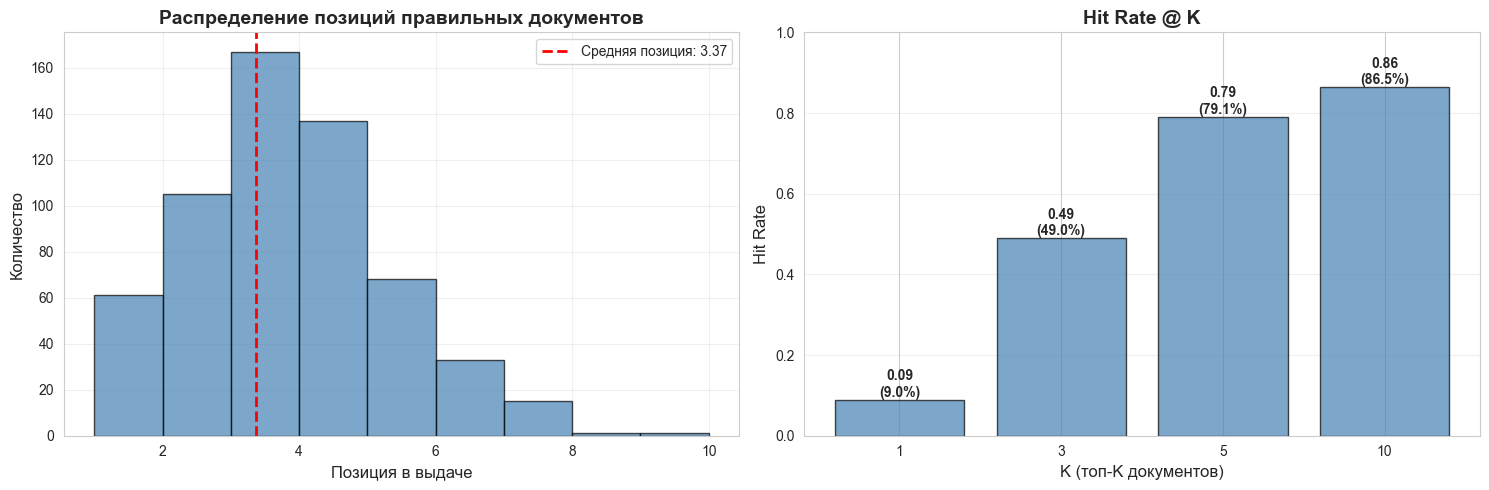

In [8]:
# Визуализация распределения позиций
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График 1: Распределение позиций
positions = retrieval_metrics['doc_positions']
positions_found = [p for p in positions if p > 0]

ax1 = axes[0]
if positions_found:
    ax1.hist(positions_found, bins=range(1, max(positions_found)+2), edgecolor='black', alpha=0.7, color='steelblue')
    ax1.axvline(retrieval_metrics['avg_position'], color='red', linestyle='--', 
               linewidth=2, label=f'Средняя позиция: {retrieval_metrics["avg_position"]:.2f}')
ax1.set_xlabel('Позиция в выдаче', fontsize=12)
ax1.set_ylabel('Количество', fontsize=12)
ax1.set_title('Распределение позиций правильных документов', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# График 2: Hit Rate @ K
ax2 = axes[1]
k_values = [1, 3, 5, 10]
hit_rates = [retrieval_metrics[f'hit_rate@{k}'] for k in k_values]
bars = ax2.bar([str(k) for k in k_values], hit_rates, color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('K (топ-K документов)', fontsize=12)
ax2.set_ylabel('Hit Rate', fontsize=12)
ax2.set_title('Hit Rate @ K', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1.0)
ax2.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, rate in zip(bars, hit_rates):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{rate:.2f}\n({rate*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)


In [9]:
# Импортируем дополнительные метрики
from ragas.metrics import answer_correctness, answer_similarity

# Выбираем метрики для оценки
# Используем все доступные метрики, так как у нас есть ground_truth!
metrics_to_evaluate = [
    # Базовые метрики
    faithfulness,        # Достоверность (нет галлюцинаций)
    answer_relevancy,    # Релевантность ответа вопросу
    context_precision,   # Точность извлеченного контекста
    context_recall,      # Полнота извлеченного контекста
    # Продвинутые метрики (требуют ground_truth)
    answer_correctness,  # Правильность ответа
    answer_similarity,   # Семантическая схожесть с эталоном
]

print("📊 Выбранные метрики:")
print("\n🔹 Базовые метрики:")
for metric in metrics_to_evaluate[:4]:
    print(f"  - {metric.name}")
print("\n✨ Продвинутые метрики (с ground_truth):")
for metric in metrics_to_evaluate[4:]:
    print(f"  - {metric.name}")


📊 Выбранные метрики:

🔹 Базовые метрики:
  - faithfulness
  - answer_relevancy
  - context_precision
  - context_recall

✨ Продвинутые метрики (с ground_truth):
  - answer_correctness
  - answer_similarity


In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

print("Запуск параллельной оценки Ragas...\n")
print(f"Датасет: {len(ragas_dataset)} примеров")
print(f"Метрики: {len(metrics_to_evaluate)}")

# Настройки параллелизма
BATCH_SIZE = 5  # Размер одного батча
MAX_WORKERS = 2  # Количество параллельных потоков

num_batches = (len(ragas_dataset) + BATCH_SIZE - 1) // BATCH_SIZE

print(f"Батчей: {num_batches}")
print(f"Параллельных потоков: {MAX_WORKERS}")

def evaluate_batch(batch_data):
    """Оценивает один батч данных"""
    batch_idx, batch_dataset = batch_data
    try:
        result = evaluate(
            dataset=batch_dataset,
            metrics=metrics_to_evaluate,
            llm=evaluator_llm,
            embeddings=evaluator_embeddings,
        )
        return (batch_idx, result, None)
    except Exception as e:
        return (batch_idx, None, str(e))

try:
    start_time = time.time()
    
    # Создаем батчи
    batches = []
    for i in range(num_batches):
        start_idx = i * BATCH_SIZE
        end_idx = min((i + 1) * BATCH_SIZE, len(ragas_dataset))
        batch_indices = list(range(start_idx, end_idx))
        batch_dataset = ragas_dataset.select(batch_indices)
        batches.append((i, batch_dataset))
    
    # Параллельная обработка
    all_results = [None] * num_batches
    errors = []
    completed = 0
    
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {executor.submit(evaluate_batch, batch): batch[0] for batch in batches}
        
        for future in as_completed(futures):
            batch_idx, result, error = future.result()
            completed += 1
            
            if error:
                print(f"❌ Батч {batch_idx + 1}/{num_batches}: ОШИБКА - {error}")
                errors.append((batch_idx, error))
            else:
                all_results[batch_idx] = result
                elapsed = time.time() - start_time
                avg_time = elapsed / completed
                remaining = (num_batches - completed) * avg_time / MAX_WORKERS
                print(f"✅ Батч {batch_idx + 1}/{num_batches} завершен | "
                      f"Прогресс: {completed}/{num_batches} | "
                      f"Осталось: ~{remaining/60:.1f} мин")
    
    if errors:
        print(f"\n⚠️ Ошибок: {len(errors)}")
        for batch_idx, error in errors:
            print(f"  Батч {batch_idx + 1}: {error}")
        raise Exception(f"Некоторые батчи завершились с ошибками")
    
    # Объединяем результаты
    print("\n🔄 Объединение результатов...")
    results_dfs = [r.to_pandas() for r in all_results if r is not None]
    results_df = pd.concat(results_dfs, ignore_index=True)
    
    # Создаем объект results для совместимости с остальным кодом
    class CombinedResults:
        def __init__(self, df):
            self._df = df
        def to_pandas(self):
            return self._df
    
    results = CombinedResults(results_df)
    
    total_time = time.time() - start_time
    print(f"\n✅ Параллельная оценка завершена успешно!")
    print(f"📊 Обработано примеров: {len(results_df)}")
    print(f"⏱️ Общее время: {total_time/60:.1f} минут")
    print(f"⚡ Скорость: {len(results_df)/total_time:.1f} примеров/сек")
    
except Exception as e:
    print(f"\n❌ Ошибка при оценке: {e}")
    print("\nВозможные причины:")
    print("1. Проблемы с API ключом OpenAI или base_url")
    print("2. Недостаточно данных в датасете")
    print("3. Проблемы с форматом данных")
    print("4. Превышен rate limit API")
    raise


In [11]:

results

### 10.2 Интерпретация метрик

**Как читать результаты:**

#### Базовые метрики:

- **Faithfulness (0-1)**: 
  - > 0.9: отлично, нет галлюцинаций
  - 0.7-0.9: хорошо
  - < 0.7: модель добавляет факты не из контекста

- **Answer Relevancy (0-1)**:
  - > 0.8: отлично, ответ релевантен вопросу
  - 0.6-0.8: хорошо
  - < 0.6: ответ уходит от темы

- **Context Precision (0-1)**:
  - > 0.7: отлично, контекст точный
  - 0.5-0.7: хорошо
  - < 0.5: много нерелевантного контекста

- **Context Recall (0-1)**:
  - > 0.7: отлично, контекст полный
  - 0.5-0.7: хорошо
  - < 0.5: недостаточно информации в контексте

#### Продвинутые метрики (с ground_truth):

- **Answer Correctness (0-1)**:
  - > 0.8: отлично, ответ правильный
  - 0.6-0.8: хорошо, основные факты верны
  - < 0.6: ответ содержит ошибки

- **Answer Similarity (0-1)**:
  - > 0.8: отлично, высокая семантическая схожесть
  - 0.6-0.8: хорошо, смысл передан
  - < 0.6: ответ отличается от эталона


## 10. Подготовка данных для анализа


In [12]:
# Конвертируем результаты Ragas в DataFrame
results_df = results.to_pandas()

# Извлекаем только метрики (исключаем колонки с данными)
# Ragas использует названия: user_input, response, retrieved_contexts, reference
data_columns = ['user_input', 'response', 'retrieved_contexts', 'reference',
                'question', 'answer', 'contexts', 'ground_truth', 
                'retrieved_docs', 'expected_doc', 'doc_positions']

metric_columns = [col for col in results_df.columns 
                  if col not in data_columns]

print("📊 Результаты оценки:")
print(f"  - Количество примеров: {len(results_df)}")
print(f"  - Метрики: {', '.join(metric_columns)}")
print(f"\nПервые 3 строки метрик:")
print(results_df[metric_columns].head(3))


📊 Результаты оценки:
  - Количество примеров: 680
  - Метрики: faithfulness, answer_relevancy, context_precision, context_recall, answer_correctness, answer_similarity

Первые 3 строки метрик:
   faithfulness  answer_relevancy  context_precision  context_recall  \
0      0.428571          0.421300           0.000000             0.0   
1      0.000000          0.688424           0.000000             1.0   
2      1.000000          0.519369           0.638889             1.0   

   answer_correctness  answer_similarity  
0            0.116223           0.464930  
1            0.129403           0.517601  
2            0.338574           0.754296  


In [13]:
results_df.to_json('result_ragas.json')
results_df


,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,context_precision,context_recall,answer_correctness,answer_similarity
0,Какой обзор является основным источником матер...,[## скользящее среднее в знаменателе adagrad. ...,"Основным источником материала в документе, кро...",Обзор Х. Брендана МакМахана под названием «A S...,0.428571,0.421300,0.000000,0.0,0.116223,0.464930
1,Какие два основных типа регуляризаторов выделя...,[## регуляризация всегда ли решение задачи рег...,В классе алгоритмов Follow The Regularized Lea...,"Центрированные регуляризаторы, минимум которых...",0.000000,0.688424,0.000000,1.0,0.129403,0.517601
2,Как называется ключевая лемма для оценки качес...,[## follow the regularized leader чтобы стабил...,Ключевая лемма для оценки качества работы алго...,Strong FTRL Lemma. Она помогает оценить верхню...,1.000000,0.519369,0.638889,1.0,0.338574,0.754296
3,Почему на практике удобно использовать диагона...,[### data-adaptive ftrl до сих пор мы рассматр...,Использование диагональных матриц в адаптивных...,Потому что диагональные матрицы требуют горазд...,0.352941,0.902316,1.000000,1.0,0.418989,0.675954
4,Зачем вводят квадратичные регуляризаторы при п...,[## оглавление часть 1. введение - постановка ...,Квадратичные регуляризаторы вводят при построе...,Они упрощают анализ: для них легко подобрать п...,0.000000,0.820067,0.500000,0.0,0.114289,0.457156
...,...,...,...,...,...,...,...,...,...,...
675,Что такое MRR (Mean Reciprocal Rank)?,"[### бинарная релевантность величина, которая ...",### Средний обратный ранг (MRR)\n\n**Определен...,"MRR — это метрика качества ранжирования, равна...",NaN,NaN,NaN,NaN,NaN,NaN
676,Как работает метод RankNet?,[### попарный подход начнём рассмотрение попар...,Метод RankNet — это алгоритм обучения ранжиров...,"RankNet — это попарный метод, который обучает ...",NaN,NaN,NaN,NaN,NaN,NaN
677,Что такое LambdaRank и в чём его цель?,[### ndcg введём метрику dcg (discounted cumul...,### Что такое LambdaRank?\n\nLambdaRank — это ...,"LambdaRank — это попарный метод, который модиф...",NaN,NaN,NaN,NaN,NaN,NaN
678,Какие популярные признаки используются в задач...,[## практические советы ### популярные признак...,В задаче ранжирования признаки можно разделить...,"Популярные признаки: TF-IDF, BM25, косинусная ...",NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Загружаем результаты
results_df = pd.read_json('result_ragas.json')

print(f"Всего строк до очистки: {len(results_df)}")
print(f"Строк с NaN значениями: {results_df.isna().any(axis=1).sum()}")

# Определяем колонки метрик (все числовые колонки, кроме данных)
data_columns = ['user_input', 'response', 'retrieved_contexts', 'reference', 
                'question', 'answer', 'contexts', 'ground_truth',
                'retrieved_docs', 'expected_doc', 'doc_positions']
metric_columns = [col for col in results_df.columns if col not in data_columns]

print(f"\nКолонки метрик для анализа: {metric_columns}")

# Удаляем строки, где ВСЕ метрики равны NaN (это ошибки запросов)
# Строка считается ошибочной, если все метрики NaN
results_df_clean = results_df.dropna(subset=metric_columns, how='all')

print(f"\nУдалено строк с ошибками (все метрики NaN): {len(results_df) - len(results_df_clean)}")
print(f"Осталось строк после очистки: {len(results_df_clean)}")

# Проверяем, есть ли еще NaN в отдельных метриках
nan_counts = results_df_clean[metric_columns].isna().sum()
if nan_counts.any():
    print("\nВнимание! Есть NaN в отдельных метриках:")
    print(nan_counts[nan_counts > 0])
    
    # Опционально: заполняем оставшиеся NaN нулями или удаляем
    # Вариант 1: Удалить строки с любыми NaN в метриках
    # results_df_clean = results_df_clean.dropna(subset=metric_columns, how='any')
    
    # Вариант 2: Заполнить NaN нулями (осторожно, может исказить статистику!)
    # results_df_clean[metric_columns] = results_df_clean[metric_columns].fillna(0)
else:
    print("\n✓ Все метрики заполнены корректно!")

# Используем очищенный датафрейм для дальнейшего анализа
results_df = results_df_clean

# Показываем статистику по метрикам
print("\n" + "="*60)
print("Статистика метрик после очистки:")
print("="*60)
print(results_df[metric_columns].describe())

Всего строк до очистки: 680
Строк с NaN значениями: 163

Колонки метрик для анализа: ['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall', 'answer_correctness', 'answer_similarity']

Удалено строк с ошибками (все метрики NaN): 28
Осталось строк после очистки: 652

Внимание! Есть NaN в отдельных метриках:
faithfulness          12
answer_relevancy       8
context_precision     64
context_recall         4
answer_correctness    63
answer_similarity     26
dtype: int64

Статистика метрик после очистки:
       faithfulness  answer_relevancy  context_precision  context_recall  \
count    640.000000        644.000000         588.000000      648.000000   
mean       0.852527          0.784737           0.852009        0.916229   
std        0.195359          0.229898           0.231780        0.255120   
min        0.000000          0.000000           0.000000        0.000000   
25%        0.750000          0.706228           0.805556        1.000000   
50%        0.928571

### 10.1 Средние значения метрик


In [14]:
print("="*80)
print("📈 СРЕДНИЕ ЗНАЧЕНИЯ МЕТРИК")
print("="*80)
print()

for metric in metric_columns:
    mean_value = results_df[metric].mean()
    std_value = results_df[metric].std()
    min_value = results_df[metric].min()
    max_value = results_df[metric].max()
    
    print(f"{metric:25s}: {mean_value:.4f} (±{std_value:.4f})")
    print(f"{'':25s}  min: {min_value:.4f}, max: {max_value:.4f}")
    print()

print("="*80)


📈 СРЕДНИЕ ЗНАЧЕНИЯ МЕТРИК

faithfulness             : 0.8525 (±0.1954)
                           min: 0.0000, max: 1.0000

answer_relevancy         : 0.7847 (±0.2299)
                           min: 0.0000, max: 1.0000

context_precision        : 0.8520 (±0.2318)
                           min: 0.0000, max: 1.0000

context_recall           : 0.9162 (±0.2551)
                           min: 0.0000, max: 1.0000

answer_correctness       : 0.4283 (±0.2178)
                           min: 0.0457, max: 0.9550

answer_similarity        : 0.6025 (±0.1222)
                           min: 0.1829, max: 0.8814



## 11. Визуализация результатов


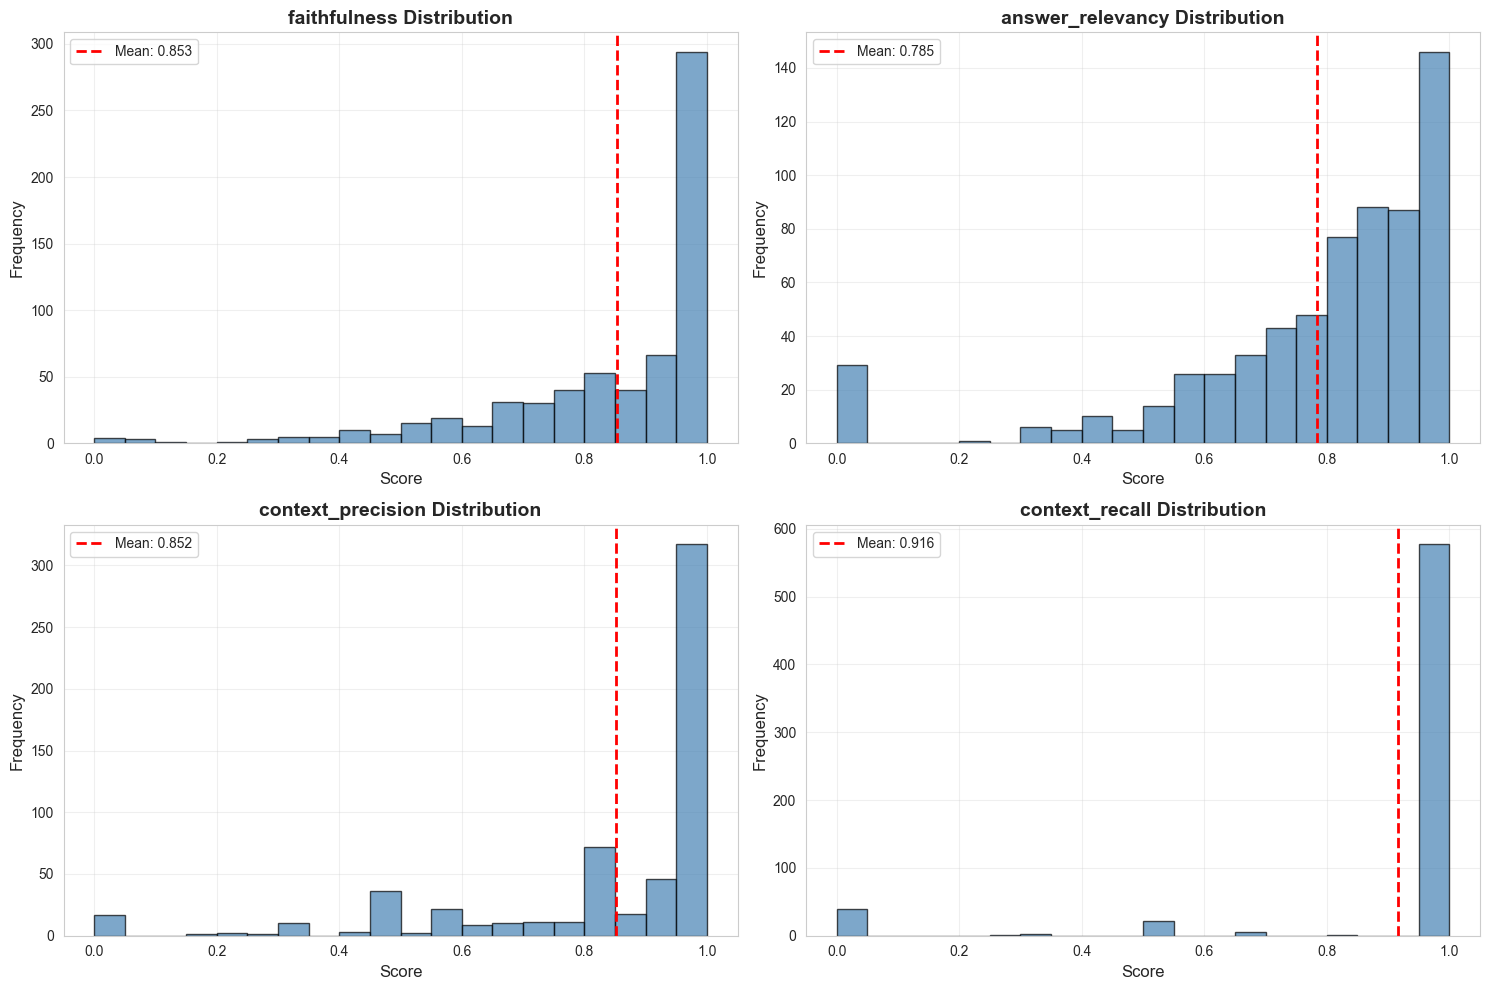

In [15]:
# Создаем гистограммы для каждой метрики
n_metrics = len(metric_columns)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, metric in enumerate(metric_columns):
    if i < len(axes):
        ax = axes[i]
        ax.hist(results_df[metric], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
        ax.axvline(results_df[metric].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {results_df[metric].mean():.3f}')
        ax.set_xlabel('Score', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title(f'{metric} Distribution', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)

# Убираем лишние оси если метрик меньше 4
for i in range(n_metrics, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


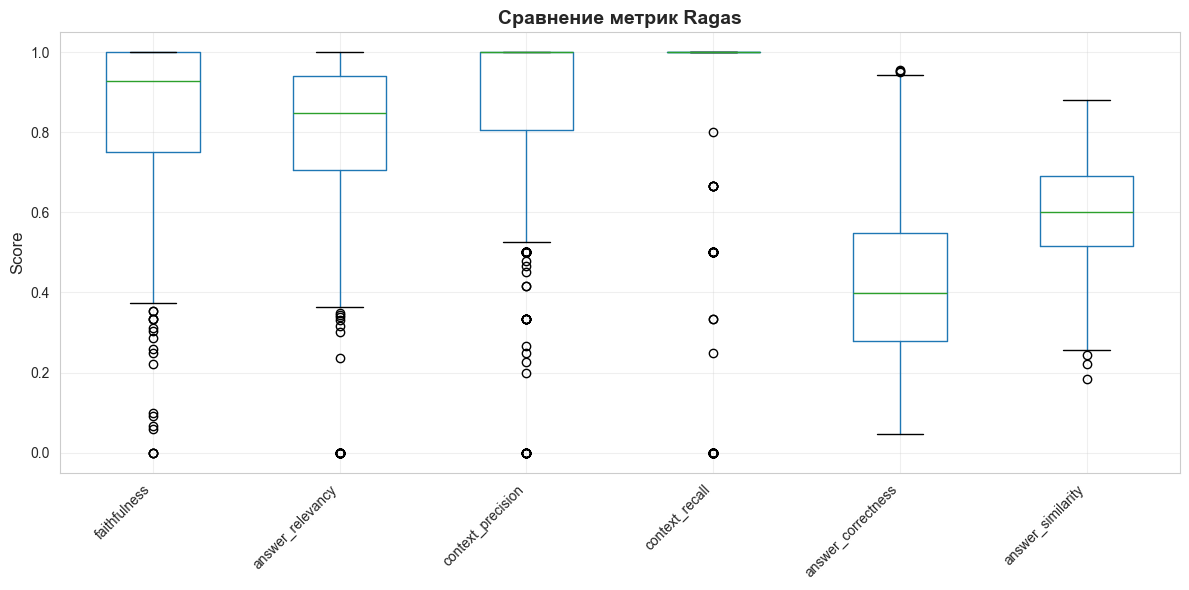

In [16]:
# Box plot для всех метрик
plt.figure(figsize=(12, 6))
results_df[metric_columns].boxplot()
plt.ylabel('Score', fontsize=12)
plt.title('Сравнение метрик Ragas', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
